## Load packages

In [1]:
%matplotlib inline 
import rdflib, glob, pandas as pd
from rdflib import URIRef
from rdflib.namespace import RDF, RDFS

## Define namespaces

In [2]:
abri = rdflib.Namespace("https://bradleypallen.org/anything-but-routine-ld/4.0/instance/")
abrw = rdflib.Namespace("https://bradleypallen.org/anything-but-routine-ld/4.0/work/")
bf = rdflib.Namespace("http://id.loc.gov/ontologies/bibframe/")
arm = rdflib.Namespace("https://w3id.org/arm/core/ontology/0.1/")

## Parse all edited .ttl files into a graph

In [3]:
def initialize_abr_graph():
    g = rdflib.Graph()
    g.bind("abri", "https://bradleypallen.org/anything-but-routine-ld/4.0/instance/")
    g.bind("abrw", "https://bradleypallen.org/anything-but-routine-ld/4.0/work/")
    g.bind("bf", "http://id.loc.gov/ontologies/bibframe/")
    g.bind("arm", "https://w3id.org/arm/core/ontology/0.1/")
    return g

In [4]:
g = initialize_abr_graph()
for infile in glob.glob("edited-ttl/*/*.ttl"):
    g.parse(infile, format='n3')
n = len(g)
print(f"ABR graph has {n} triples.")

ABR graph has 8675 triples.


## Query the graph to create a dataframe

In [5]:
qres = g.query(
    """SELECT DISTINCT ?title ?abrno ?date ?i
       WHERE {
          ?w rdf:type bf:Work .
          ?w rdfs:label ?title .
          ?i bf:instanceOf ?w .
          ?i bf:identifiedBy ?id .
          ?id bf:source 'Schottlaender v4.0' .
          ?id rdf:value ?abrno .
          ?i bf:provisionActivity ?pa .
          ?pa bf:date ?date .
       }
       ORDER BY ASC(?date)""")

results = [ [row[0].toPython(), row[1].toPython(), row[2].toPython(), row[3].toPython() ] for row in qres ]
instance_df = pd.DataFrame(results, columns=['worktitle', 'id', 'date', 'instance'])
instance_df['workid'] = instance_df['id'].str[1:-1]
instance_df['workid'] = instance_df['workid'].apply(pd.to_numeric)
instance_df['instanceltr'] = instance_df['id'].str[-1]
instance_df['instanceltr'] = instance_df['instanceltr'].str.upper()
instance_df['year'] = instance_df['date'].str.extract('\[?(\d\d\d\d)', expand=False)
instance_df = instance_df.sort_values(by=['workid', 'instanceltr'])

## Use the dataframe to plot publications over year

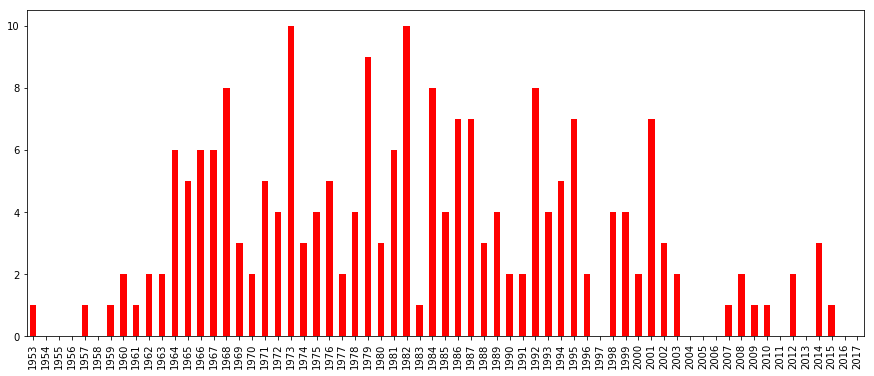

In [6]:
pub_years = instance_df['year'].value_counts().to_dict()
for year in range(1953, 2018):
    if '{}'.format(year) not in pub_years:
        pub_years['{}'.format(year)] = 0
pub_df = pd.DataFrame({'year': pub_years })
pub_df['year'].plot(kind='bar',figsize=[15, 6], color='red')